# Playing with duck db

[DuckDB](https://duckdb.org/) is an excellent complement to pandas.
It allows doing SQL queries on a table, pandas data frames, CSV files, [parquet](https://parquet.apache.org/) files, etc.
It also allows to do spatial queries on geo data.

You need to download the suburbs' data from the NSW government and store it in the data/geo/suburbs folder.
You also need to have the CSV generated from the [[rent_analysis.ipynb]] notebook in the data folder.

In [20]:
import duckdb
import geopandas as gpd

# Create a database in memory, no save
db = duckdb.connect(database=':memory:', read_only=False)
# Install spatial module for geo data
db.execute("INSTALL 'spatial'")
# Load it
db.execute("LOAD 'spatial'")

## Create a table

We can now start to import the data from the last time. We can use the CSV output of the rent_analysis from to import the data into duckdb.

Duckdb has a function to automatically detect the schema of the CSV file and create a table with the right schema.

### Loading remote data
In this exemple i use a local file, but duckdb can also load remote data. For example, you can load a CSV/parquet file from a URL.

```python
# You can also load a parquet file
db.sql("CREATE OR REPLACE TABLE rental AS SELECT * FROM read_parquet_auto('data/rentals.parquet')")
# With the httpfs you can event get the data from a remote server
db.sql("CREATE OR REPLACE TABLE rental AS SELECT * FROM read_csv_auto('http://exemple.com/rentals.csv')")
# or load a parquet file from S3
db.sql("CREATE OR REPLACE TABLE rental AS SELECT * FROM read_parquet_auto('s3://bucket/rentals.parquet')")
```

With the CSV file, the whole content is downloaded and loaded into DuckDB. With the [parquet](https://parquet.apache.org/) file, only the metadata is loaded and the data is loaded on demand.

In [21]:
# Use the read_csv_auto function to automatically detect the schema + load all the row in the rental table
db.sql("CREATE OR REPLACE TABLE rental AS SELECT * FROM read_csv_auto('data/rentals.csv')")

# Show this works
db.sql("SELECT * FROM rental LIMIT 10").df()

,Lodgement Date,Postcode,Dwelling Type,Bedrooms,Weekly Rent
0,2020-10-20,2000,F,0,475
1,2020-10-31,2000,F,0,420
2,2020-10-29,2000,F,0,410
3,2020-10-28,2000,F,0,300
4,2020-10-06,2000,F,0,340
5,2020-10-09,2000,F,0,360
6,2020-10-12,2000,F,0,250
7,2020-10-13,2000,F,0,390
8,2020-10-12,2000,F,0,400
9,2020-10-01,2000,F,0,370


The `.df()` allows to convert the result of the query into a pandas data frame. This can be used for further analysis.

In [22]:
# We can use the describe function to understand how the data are stored
db.sql("DESCRIBE rental").df()

,column_name,column_type,null,key,default,extra
0,Lodgement Date,DATE,YES,NaN,NaN,NaN
1,Postcode,BIGINT,YES,NaN,NaN,NaN
2,Dwelling Type,VARCHAR,YES,NaN,NaN,NaN
3,Bedrooms,BIGINT,YES,NaN,NaN,NaN
4,Weekly Rent,BIGINT,YES,NaN,NaN,NaN


In [23]:
# Load the suburbs' data from the government shapefile

# The st_geomfromwkb function is used to convert the binary data into a geometry object, which can be used for spatial queries
# The st_read function is used to read the shapefile (this can also work with other formats like geojson)
db.sql("CREATE OR REPLACE TABLE suburbs AS SELECT suburbname as name, postcode, ST_GeomFromWKB(wkb_geometry) as geometry, wkb_geometry  FROM ST_read('data/geo/suburbs/Suburb.shp')")

# Show this works
db.sql("SELECT * FROM suburbs LIMIT 10").df()


,name,postcode,geometry,wkb_geometry
0,TANGLEWOOD,2488,"[0, 2, 133, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0...","[1, 3, 0, 0, 0, 1, 0, 0, 0, 87, 0, 0, 0, 215, ..."
1,BUNGALORA,2486,"[0, 2, 181, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0...","[1, 3, 0, 0, 0, 1, 0, 0, 0, 89, 1, 0, 0, 60, 1..."
2,UPPER CRYSTAL CREEK,2484,"[0, 2, 31, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0,...","[1, 3, 0, 0, 0, 1, 0, 0, 0, 240, 0, 0, 0, 238,..."
3,CHINDERAH,2487,"[0, 2, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, ...","[1, 3, 0, 0, 0, 1, 0, 0, 0, 65, 2, 0, 0, 23, 2..."
4,KINCUMBER,2251,"[0, 2, 224, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0...","[1, 3, 0, 0, 0, 1, 0, 0, 0, 14, 1, 0, 0, 73, 2..."
5,PHEGANS BAY,2256,"[0, 2, 11, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0,...","[1, 3, 0, 0, 0, 1, 0, 0, 0, 176, 1, 0, 0, 112,..."
6,BOX HEAD,2257,"[0, 2, 90, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0,...","[1, 3, 0, 0, 0, 1, 0, 0, 0, 161, 7, 0, 0, 88, ..."
7,KILLCARE HEIGHTS,2257,"[0, 2, 195, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0...","[1, 3, 0, 0, 0, 1, 0, 0, 0, 60, 1, 0, 0, 233, ..."
8,COASTERS RETREAT,2108,"[0, 2, 65, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0,...","[1, 3, 0, 0, 0, 1, 0, 0, 0, 20, 1, 0, 0, 185, ..."
9,BEROWRA,2081,"[0, 2, 211, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0...","[1, 3, 0, 0, 0, 1, 0, 0, 0, 62, 2, 0, 0, 128, ..."


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4587 entries, 0 to 4586
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   name          4587 non-null   object  
 1   postcode      4579 non-null   float64 
 2   wkb_geometry  4587 non-null   geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 107.6+ KB


<Axes: >

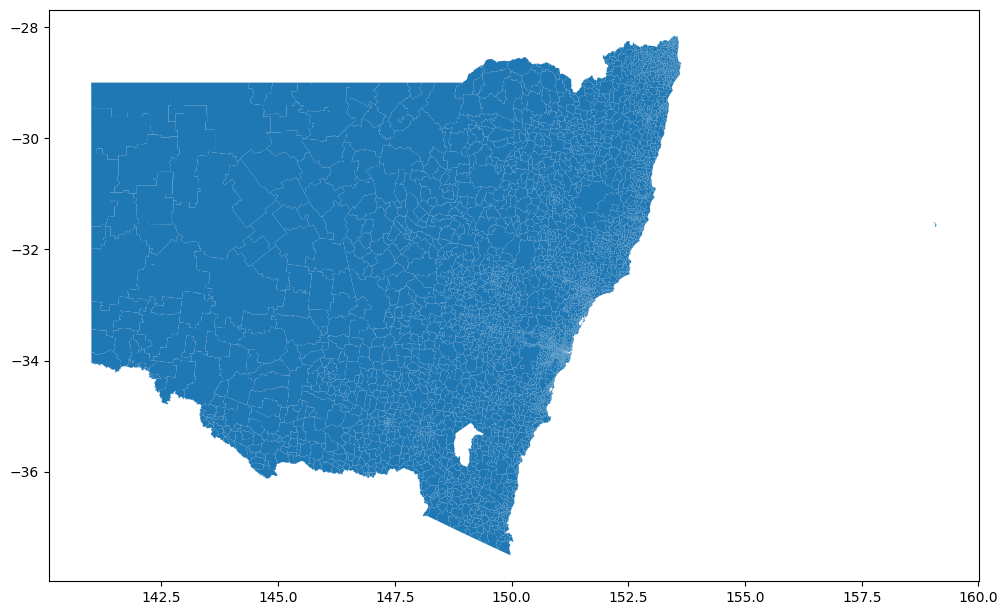

In [24]:

df = gpd.GeoDataFrame.from_records(db.sql("SELECT name, postcode, wkb_geometry FROM suburbs").fetchall(), columns=['name', 'postcode', 'wkb_geometry'], )

# convert the wkb_geometry to a shape object, the wkb is the binary format of the geometry object
df['wkb_geometry'] = gpd.GeoSeries.from_wkb(df['wkb_geometry'])
# Set the geometry column
df.set_geometry('wkb_geometry', inplace=True, crs='EPSG:4283')
df.info()

# Draw the map
df.plot(figsize=(12, 8))

We can use geopandas to do a [Choropleth](https://en.wikipedia.org/wiki/Choropleth_map) map of the rental price per suburb.

Text(0.5, 1.0, 'Weekly Rent in Sydney since 2023')

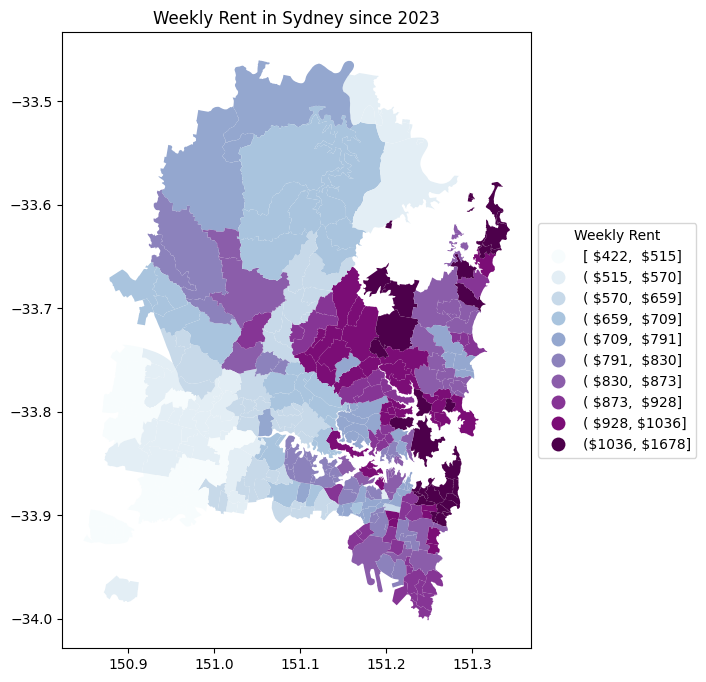

In [25]:
# Do a Choropleth of the rental price per suburb

# we do the join with the postcode and filter for logement date > 2023
query = db.sql("""
SELECT
    suburbs.name as name,
    suburbs.postcode,
    wkb_geometry,
    AVG("Weekly Rent") as price
FROM
    rental
    JOIN suburbs ON rental.postcode = suburbs.postcode
WHERE
    rental.postcode >= 2000 and rental.postcode < 2170
    AND "Lodgement Date" >= '2023-01-01'
GROUP BY
    name, suburbs.postcode, wkb_geometry
""")

df = gpd.geodataframe.GeoDataFrame.from_records(query.fetchall(), columns=['name', 'postcode', 'wkb_geometry', 'price'], )# .plot(column='price', legend=True)

# convert the wkb_geometry to a shape object, the wkb is the binary format of the object
df['wkb_geometry'] = gpd.GeoSeries.from_wkb(df['wkb_geometry'])
# Set the geometry column
df.set_geometry('wkb_geometry', inplace=True, crs='EPSG:4283')

%matplotlib inline
ax = df.plot(
    column="price",
    scheme="QUANTILES",
    k=10,
    cmap="BuPu",
    legend=True,
    legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "fmt": "\${:.0f}",  "interval": True, "title": "Weekly Rent"},
    figsize=(12, 8),
)
# add the title
ax.set_title("Weekly Rent in Sydney since 2023")
# df.info()

You can also mix and match pandas and duckdb. For example, we can use pandas to do a pivot table of the rental price per suburb and per number of bedrooms.

In [26]:
# Get all the rental data
df_rentals = db.sql('SELECT * FROM rental where "Bedrooms" <= 5').df()
# Remove outliers by using the 95% percentile and 5% percentile
df_rentals = df_rentals[df_rentals['Weekly Rent'] < df_rentals['Weekly Rent'].quantile(0.95)]
df_rentals = df_rentals[df_rentals['Weekly Rent'] > df_rentals['Weekly Rent'].quantile(0.05)]
# Now use ducbdb to create statistics on the data
stats = db.sql("""
select "Bedrooms", AVG("Weekly Rent") as "Average Rent", COUNT(*) as "Number of Rentals" from df_rentals group by "Bedrooms"
""").df()
# you can observe we have referenced the df_rentals dataframe in the query like a normal table
print(stats.head(10))

   Bedrooms  Average Rent  Number of Rentals
0         3    520.469630             395967
1         4    582.908625             174698
2         5    675.984479              23581
3         2    513.430800             622049
4         1    473.205749             302228
5         0    411.660589              19307


The possibility to combine pandas and duckdb is very powerful. It allows doing complex analysis on large dataset.